In [ ]:
import json

data = [
    ["age", "fbs"],
    ["fbs", "target"],
    ["target", "chol"],
    ["target", "thalach"]
]

with open('structure.json', 'w') as f:
    json.dump(data, f, indent=4)

print("File structure.json created successfully.")

File structure.json created successfully.


In [ ]:
!pip install pgmpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

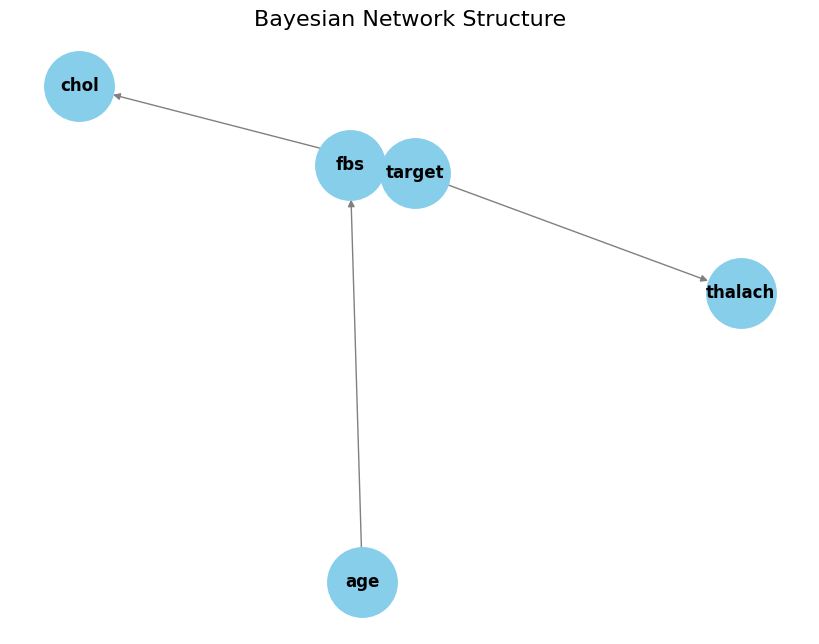


Enter evidence using RAW values (e.g., age=58, fbs=130):
Available columns for evidence: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
>>> 37

🔎 Inference Results:

P(age | evidence={}):
+--------------------------+------------+
| age                      |   phi(age) |
+==========================+============+
| age(0.0)                 |     0.0033 |
+--------------------------+------------+
| age(0.10416666666666663) |     0.0066 |
+--------------------------+------------+
| age(0.125)               |     0.0132 |
+--------------------------+------------+
| age(0.16666666666666663) |     0.0066 |
+--------------------------+------------+
| age(0.1875)              |     0.0066 |
+--------------------------+------------+
| age(0.20833333333333337) |     0.0132 |
+--------------------------+------------+
| age(0.22916666666666663) |     0.0099 |
+--------------------------+------------+
| age(0.25)          

In [ ]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.drop_duplicates()
    df = df.dropna()

    # Save cleaned data
    df.to_csv("cleaned_heartdisease.csv", index=False)

    return df

def normalize_data(df):
    numeric_cols = df.select_dtypes(include='number').columns
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df, scaler

def load_structure(json_path):
    with open(json_path, 'r') as file:
        structure = json.load(file)
    return structure

def build_and_train_model(df, structure):
    model = DiscreteBayesianNetwork(structure)
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    return model

def visualize_structure(structure):
    G = nx.DiGraph()
    G.add_edges_from(structure)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=2500, node_color='skyblue', font_size=12, font_weight='bold', arrows=True, edge_color='gray')
    plt.title("Bayesian Network Structure", fontsize=16)
    plt.show()

def get_raw_evidence_input(columns, scaler, df):
    print("\nEnter evidence using RAW values (e.g., age=58, fbs=130):")
    print("Available columns for evidence:", list(columns))
    raw_input_text = input(">>> ")

    raw_evidence = {}
    for item in raw_input_text.split(','):
        if '=' in item:
            key, value = item.split('=')
            key = key.strip()
            try:
                raw_value = float(value.strip())
                raw_evidence[key] = raw_value
            except ValueError:
                print(f"Invalid value for {key}. Skipping.")

    # Normalize raw input using fitted scaler
    evidence = {}
    for key, raw_val in raw_evidence.items():
        if key in scaler.feature_names_in_:
            col_index = list(scaler.feature_names_in_).index(key)
            col_min = df[key].min()
            col_max = df[key].max()
            normalized_val = (raw_val - col_min) / (col_max - col_min)
            normalized_val = max(0.0, min(1.0, normalized_val))  # Clip between 0–1
            evidence[key] = normalized_val
        else:
            # For categorical inputs like target (0 or 1), use as-is
            evidence[key] = raw_val

    return evidence

def run_inference(model, evidence_input):
    inference = VariableElimination(model)
    print("\n🔎 Inference Results:")
    for variable in model.nodes():
        if variable not in evidence_input:
            result = inference.query(variables=[variable], evidence=evidence_input)
            print(f"\nP({variable} | evidence={evidence_input}):\n{result}")

if __name__ == "__main__":
    csv_path = "/heart_disease.csv"
    json_path = "/structure.json"

    df_raw = load_data(csv_path)
    df_normalized, scaler = normalize_data(df_raw.copy())
    structure = load_structure(json_path)

    visualize_structure(structure)

    model = build_and_train_model(df_normalized, structure)

    # Get user input in raw form and normalize it
    evidence = get_raw_evidence_input(df_raw.columns, scaler, df_raw)
    run_inference(model, evidence)
